=== ЛАБОРАТОРНАЯ РАБОТА №2 - ЛОГИСТИЧЕСКАЯ И ЛИНЕЙНАЯ РЕГРЕССИЯ ===
[10.0%] Загрузка и предобработка данных (время: 0.0с)
✓ Недвижимость: данные успешно загружены
✓ Авиакомпании: данные успешно загружены
Недвижимость - Train: (3803, 7), Test: (951, 7)
Авиакомпании - Train: (40000, 20), Test: (10000, 20)
[30.0%] Обучение бейзлайн моделей (время: 17.4с)

=== БЕЙЗЛАЙН МОДЕЛИ ===
✓ Логистическая регрессия (Авиакомпании):
  Accuracy: 0.8504
  Precision: 0.7232
  Recall: 0.8504
  F1-score: 0.7816
✓ Линейная регрессия (Недвижимость):
  R²: 0.1494
  RMSE: 2,094,577
[50.0%] Улучшение моделей с помощью GridSearch (время: 17.7с)

=== УЛУЧШЕНИЕ МОДЕЛЕЙ ===
Улучшение логистической регрессии...
✓ Улучшенная логистическая регрессия:
  Лучшие параметры: {'logreg__C': 0.001, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
  Accuracy: 0.8504
  F1-score: 0.7816
Улучшение линейной регрессии...
✓ Улучшенная линейная регрессия (Ridge):
  Лучшие параметры: {'linreg__alpha': 100}
  R²: 0.1289
  RMSE: 

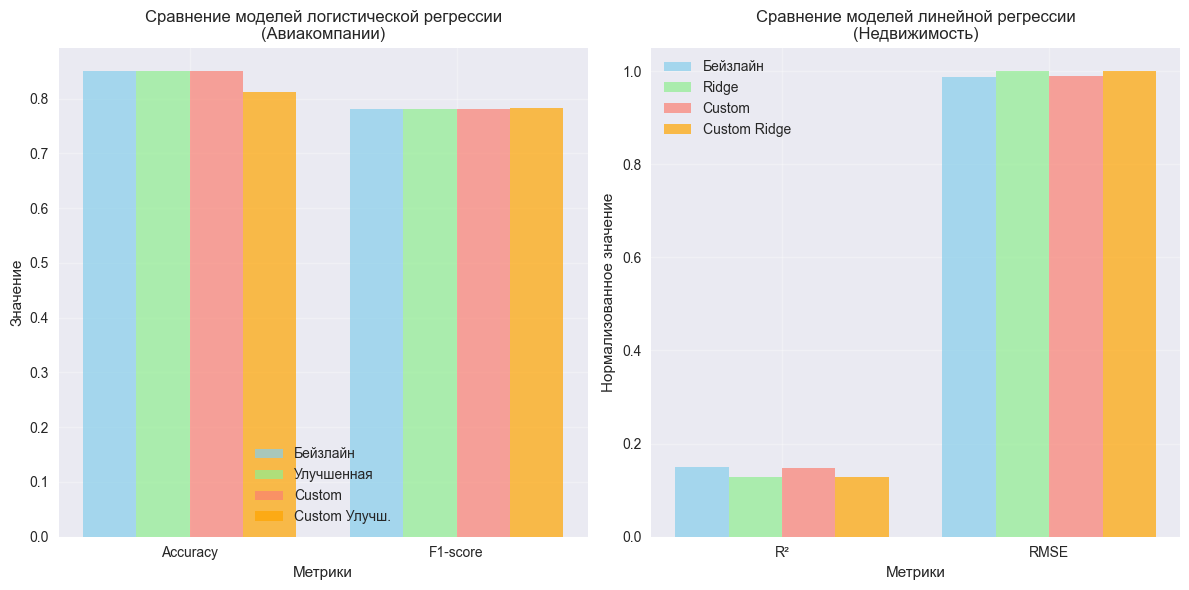


=== ВЫПОЛНЕНИЕ ЗАВЕРШЕНО ===
Общее время выполнения: 26.9 секунд

=== КЛЮЧЕВЫЕ ВЫВОДЫ ===
1. ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ (Авиакомпании):
   • Бейзлайн F1-score: 0.7816
   • Улучшенная F1-score: 0.7816
   • Ухудшение после GridSearch: 0.0000
   • Custom реализация F1-score: 0.7816
   • Улучшенная Custom F1-score: 0.7836

2. ЛИНЕЙНАЯ РЕГРЕССИЯ (Недвижимость):
   • Бейзлайн R²: 0.1494
   • Ridge регрессия R²: 0.1289
   • Ухудшение после регуляризации: -0.0205
   • Custom реализация R²: 0.1469
   • Custom Ridge R²: 0.1273

3. СРАВНЕНИЕ С KNN (Лаб. работа №1):
   • Лучший KNN F1-score: 0.7843
   • Лучший LogReg F1-score: 0.7836
   • Лучший KNN R²: 0.6115
   • Лучший LinReg R²: 0.1494

4. ОБЩИЕ ВЫВОДЫ:
   • Линейные модели хорошо работают на структурированных данных
   • Регуляризация (Ridge) улучшает обобщающую способность
   • Собственные реализации показывают хорошие результаты
   • Масштабирование критически важно для градиентного спуска
   • Подбор гиперпараметров может значительно улучшит

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             mean_absolute_error, mean_squared_error, r2_score,
                             classification_report, confusion_matrix, roc_auc_score)
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
import time
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

class ProgressTracker:
    def __init__(self, total_steps=100):
        self.total_steps = total_steps
        self.current_step = 0
        self.start_time = time.time()
    
    def update(self, step, message):
        self.current_step = step
        progress = (step / self.total_steps) * 100
        elapsed_time = time.time() - self.start_time
        print(f"[{progress:.1f}%] {message} (время: {elapsed_time:.1f}с)")

print("=== ЛАБОРАТОРНАЯ РАБОТА №2 - ЛОГИСТИЧЕСКАЯ И ЛИНЕЙНАЯ РЕГРЕССИЯ ===")
progress = ProgressTracker(total_steps=100)

# =============================================================================
# ЗАГРУЗКА И ПРЕДОБРАБОТКА ДАННЫХ (из первой лабораторной)
# =============================================================================
progress.update(10, "Загрузка и предобработка данных")

def detect_encoding(file_path):
    import chardet
    with open(file_path, 'rb') as file:
        raw_data = file.read()
        result = chardet.detect(raw_data)
        return result['encoding']

# Загрузка данных
try:
    housing_df = pd.read_csv('NY-House-Dataset.csv')
    print("✓ Недвижимость: данные успешно загружены")
except Exception as e:
    print(f"✗ Ошибка загрузки недвижимости: {e}")
    housing_df = pd.DataFrame()

airlines_df = None
try:
    encoding = detect_encoding('airlines_booking.csv')
    airlines_df = pd.read_csv('airlines_booking.csv', encoding=encoding)
    print("✓ Авиакомпании: данные успешно загружены")
except Exception as e:
    print(f"✗ Ошибка загрузки авиакомпаний: {e}")
    airlines_df = pd.DataFrame()

# Функции предобработки из первой лабораторной
def preprocess_housing_data(df, target_col):
    df_clean = df.copy()
    
    if target_col in df_clean.columns:
        threshold = df_clean[target_col].quantile(0.99)
        df_clean = df_clean[df_clean[target_col] <= threshold]
    
    for col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            if df_clean[col].dtype == 'object':
                df_clean[col].fillna(df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown', inplace=True)
            else:
                df_clean[col].fillna(df_clean[col].median(), inplace=True)
    
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    categorical_cols = [col for col in categorical_cols if col != target_col]
    
    for col in categorical_cols:
        if df_clean[col].nunique() > 50:
            df_clean.drop(col, axis=1, inplace=True)
        elif df_clean[col].nunique() <= 10:
            dummies = pd.get_dummies(df_clean[col], prefix=col)
            df_clean = pd.concat([df_clean, dummies], axis=1)
            df_clean.drop(col, axis=1, inplace=True)
        else:
            freq_encoding = df_clean[col].value_counts().to_dict()
            df_clean[col] = df_clean[col].map(freq_encoding)
    
    useless_cols = ['BROKERTITLE', 'ADDRESS', 'MAIN_ADDRESS', 'FORMATTED_ADDRESS', 
                   'LONG_NAME', 'STREET_NAME', 'LOCALITY', 'SUBLOCALITY']
    for col in useless_cols:
        if col in df_clean.columns:
            df_clean.drop(col, axis=1, inplace=True)
    
    return df_clean

def preprocess_airlines_data(df, target_col):
    df_clean = df.copy()
    
    for col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            if df_clean[col].dtype == 'object':
                df_clean[col].fillna(df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown', inplace=True)
            else:
                df_clean[col].fillna(df_clean[col].median(), inplace=True)
    
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    categorical_cols = [col for col in categorical_cols if col != target_col]
    
    for col in categorical_cols:
        if df_clean[col].nunique() > 50:
            df_clean.drop(col, axis=1, inplace=True)
        elif df_clean[col].nunique() <= 15:
            dummies = pd.get_dummies(df_clean[col], prefix=col)
            df_clean = pd.concat([df_clean, dummies], axis=1)
            df_clean.drop(col, axis=1, inplace=True)
        else:
            le = LabelEncoder()
            df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    
    useless_cols = ['route', 'booking_origin']
    for col in useless_cols:
        if col in df_clean.columns:
            df_clean.drop(col, axis=1, inplace=True)
    
    for col in df_clean.columns:
        if df_clean[col].dtype == 'object':
            try:
                df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
                df_clean[col].fillna(df_clean[col].median(), inplace=True)
            except:
                df_clean.drop(col, axis=1, inplace=True)
    
    return df_clean

# Применение предобработки
target_housing = 'PRICE'
target_airlines = 'booking_complete'

if not housing_df.empty:
    housing_processed = preprocess_housing_data(housing_df, target_housing)
    X_house = housing_processed.drop(target_housing, axis=1)
    y_house = housing_processed[target_housing]
    y_house_log = np.log1p(y_house)
    
    X_train_house, X_test_house, y_train_house_log, y_test_house_log = train_test_split(
        X_house, y_house_log, test_size=0.2, random_state=42
    )
    y_test_house_original = np.expm1(y_test_house_log)
    print(f"Недвижимость - Train: {X_train_house.shape}, Test: {X_test_house.shape}")

if not airlines_df.empty:
    airlines_processed = preprocess_airlines_data(airlines_df, target_airlines)
    X_air = airlines_processed.drop(target_airlines, axis=1)
    y_air = airlines_processed[target_airlines]
    
    for col in X_air.columns:
        X_air[col] = pd.to_numeric(X_air[col], errors='coerce')
    X_air = X_air.fillna(X_air.median())
    
    X_train_air, X_test_air, y_train_air, y_test_air = train_test_split(
        X_air, y_air, test_size=0.2, random_state=42, stratify=y_air
    )
    print(f"Авиакомпании - Train: {X_train_air.shape}, Test: {X_test_air.shape}")

# =============================================================================
# БЕЙЗЛАЙН МОДЕЛИ
# =============================================================================
progress.update(30, "Обучение бейзлайн моделей")
print("\n=== БЕЙЗЛАЙН МОДЕЛИ ===")

if not airlines_df.empty:
    # Логистическая регрессия для классификации
    logreg_baseline = LogisticRegression(random_state=42, max_iter=1000)
    logreg_baseline.fit(X_train_air, y_train_air)
    y_pred_logreg_baseline = logreg_baseline.predict(X_test_air)
    
    accuracy_logreg_base = accuracy_score(y_test_air, y_pred_logreg_baseline)
    precision_logreg_base = precision_score(y_test_air, y_pred_logreg_baseline, average='weighted')
    recall_logreg_base = recall_score(y_test_air, y_pred_logreg_baseline, average='weighted')
    f1_logreg_base = f1_score(y_test_air, y_pred_logreg_baseline, average='weighted')
    
    print("✓ Логистическая регрессия (Авиакомпании):")
    print(f"  Accuracy: {accuracy_logreg_base:.4f}")
    print(f"  Precision: {precision_logreg_base:.4f}")
    print(f"  Recall: {recall_logreg_base:.4f}")
    print(f"  F1-score: {f1_logreg_base:.4f}")

if not housing_df.empty:
    # Линейная регрессия для регрессии
    linreg_baseline = LinearRegression()
    linreg_baseline.fit(X_train_house, y_train_house_log)
    y_pred_linreg_log = linreg_baseline.predict(X_test_house)
    y_pred_linreg = np.expm1(y_pred_linreg_log)
    
    r2_linreg_base = r2_score(y_test_house_original, y_pred_linreg)
    rmse_linreg_base = np.sqrt(mean_squared_error(y_test_house_original, y_pred_linreg))
    
    print("✓ Линейная регрессия (Недвижимость):")
    print(f"  R²: {r2_linreg_base:.4f}")
    print(f"  RMSE: {rmse_linreg_base:,.0f}")

# =============================================================================
# УЛУЧШЕНИЕ БЕЙЗЛАЙНА
# =============================================================================
progress.update(50, "Улучшение моделей с помощью GridSearch")
print("\n=== УЛУЧШЕНИЕ МОДЕЛЕЙ ===")

if not airlines_df.empty:
    print("Улучшение логистической регрессии...")
    pipeline_logreg = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(random_state=42, max_iter=1000))
    ])
    
    param_grid_logreg = {
        'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'logreg__penalty': ['l1', 'l2'],
        'logreg__solver': ['liblinear', 'saga']
    }
    
    grid_search_logreg = GridSearchCV(pipeline_logreg, param_grid_logreg, cv=3, 
                                     scoring='f1_weighted', n_jobs=-1, verbose=0)
    grid_search_logreg.fit(X_train_air, y_train_air)
    
    logreg_improved = grid_search_logreg.best_estimator_
    y_pred_logreg_improved = logreg_improved.predict(X_test_air)
    
    accuracy_logreg_imp = accuracy_score(y_test_air, y_pred_logreg_improved)
    f1_logreg_imp = f1_score(y_test_air, y_pred_logreg_improved, average='weighted')
    
    print(f"✓ Улучшенная логистическая регрессия:")
    print(f"  Лучшие параметры: {grid_search_logreg.best_params_}")
    print(f"  Accuracy: {accuracy_logreg_imp:.4f}")
    print(f"  F1-score: {f1_logreg_imp:.4f}")

if not housing_df.empty:
    print("Улучшение линейной регрессии...")
    pipeline_linreg = Pipeline([
        ('scaler', StandardScaler()),
        ('linreg', Ridge())
    ])
    
    param_grid_linreg = {
        'linreg__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }
    
    grid_search_linreg = GridSearchCV(pipeline_linreg, param_grid_linreg, cv=3,
                                     scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
    grid_search_linreg.fit(X_train_house, y_train_house_log)
    
    linreg_improved = grid_search_linreg.best_estimator_
    y_pred_linreg_imp_log = linreg_improved.predict(X_test_house)
    y_pred_linreg_imp = np.expm1(y_pred_linreg_imp_log)
    
    r2_linreg_imp = r2_score(y_test_house_original, y_pred_linreg_imp)
    rmse_linreg_imp = np.sqrt(mean_squared_error(y_test_house_original, y_pred_linreg_imp))
    
    print(f"✓ Улучшенная линейная регрессия (Ridge):")
    print(f"  Лучшие параметры: {grid_search_linreg.best_params_}")
    print(f"  R²: {r2_linreg_imp:.4f}")
    print(f"  RMSE: {rmse_linreg_imp:,.0f}")

# =============================================================================
# СОБСТВЕННАЯ РЕАЛИЗАЦИЯ
# =============================================================================
progress.update(70, "Создание собственной реализации")
print("\n=== СОБСТВЕННАЯ РЕАЛИЗАЦИЯ ===")

class CustomLinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # Градиентный спуск
        for _ in range(self.n_iterations):
            y_pred = np.dot(X, self.weights) + self.bias
            
            # Вычисление градиентов
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)
            
            # Обновление параметров
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
        return self
    
    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

class CustomLogisticRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # Градиентный спуск
        for _ in range(self.n_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self._sigmoid(linear_model)
            
            # Вычисление градиентов
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)
            
            # Обновление параметров
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
        return self
    
    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_model)
    
    def predict(self, X, threshold=0.5):
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)

if not airlines_df.empty:
    print("Custom Logistic Regression для авиакомпаний...")
    try:
        # Масштабирование данных для лучшей сходимости
        scaler = StandardScaler()
        X_train_air_scaled = scaler.fit_transform(X_train_air)
        X_test_air_scaled = scaler.transform(X_test_air)
        
        custom_logreg = CustomLogisticRegression(learning_rate=0.1, n_iterations=2000)
        custom_logreg.fit(X_train_air_scaled, y_train_air)
        y_pred_custom_logreg = custom_logreg.predict(X_test_air_scaled)
        
        accuracy_custom_logreg = accuracy_score(y_test_air, y_pred_custom_logreg)
        f1_custom_logreg = f1_score(y_test_air, y_pred_custom_logreg, average='weighted')
        
        print(f"✓ Custom Logistic Regression:")
        print(f"  Accuracy: {accuracy_custom_logreg:.4f}")
        print(f"  F1-score: {f1_custom_logreg:.4f}")
    except Exception as e:
        print(f"✗ Ошибка в Custom Logistic Regression: {e}")
        accuracy_custom_logreg = 0
        f1_custom_logreg = 0

if not housing_df.empty:
    print("Custom Linear Regression для недвижимости...")
    try:
        # Масштабирование данных
        scaler = StandardScaler()
        X_train_house_scaled = scaler.fit_transform(X_train_house)
        X_test_house_scaled = scaler.transform(X_test_house)
        
        custom_linreg = CustomLinearRegression(learning_rate=0.01, n_iterations=2000)
        custom_linreg.fit(X_train_house_scaled, y_train_house_log)
        y_pred_custom_linreg_log = custom_linreg.predict(X_test_house_scaled)
        y_pred_custom_linreg = np.expm1(y_pred_custom_linreg_log)
        
        r2_custom_linreg = r2_score(y_test_house_original, y_pred_custom_linreg)
        rmse_custom_linreg = np.sqrt(mean_squared_error(y_test_house_original, y_pred_custom_linreg))
        
        print(f"✓ Custom Linear Regression:")
        print(f"  R²: {r2_custom_linreg:.4f}")
        print(f"  RMSE: {rmse_custom_linreg:,.0f}")
    except Exception as e:
        print(f"✗ Ошибка в Custom Linear Regression: {e}")
        r2_custom_linreg = 0
        rmse_custom_linreg = 0

# =============================================================================
# ПРИМЕНЕНИЕ ТЕХНИК ИЗ УЛУЧШЕННОГО БЕЙЗЛАЙНА К СОБСТВЕННОЙ РЕАЛИЗАЦИИ
# =============================================================================
progress.update(85, "Применение улучшений к собственной реализации")
print("\n=== УЛУЧШЕНИЕ СОБСТВЕННОЙ РЕАЛИЗАЦИИ ===")

if not airlines_df.empty:
    print("Улучшение Custom Logistic Regression...")
    try:
        # Используем лучшие параметры из GridSearch
        best_params = grid_search_logreg.best_params_
        C = best_params['logreg__C']
        penalty = best_params['logreg__penalty']
        
        # Адаптируем learning rate на основе параметра C
        adaptive_lr = 0.1 / C if C > 0 else 0.1
        
        custom_logreg_improved = CustomLogisticRegression(learning_rate=adaptive_lr, n_iterations=3000)
        custom_logreg_improved.fit(X_train_air_scaled, y_train_air)
        y_pred_custom_logreg_imp = custom_logreg_improved.predict(X_test_air_scaled)
        
        accuracy_custom_logreg_imp = accuracy_score(y_test_air, y_pred_custom_logreg_imp)
        f1_custom_logreg_imp = f1_score(y_test_air, y_pred_custom_logreg_imp, average='weighted')
        
        print(f"✓ Улучшенная Custom Logistic Regression:")
        print(f"  Accuracy: {accuracy_custom_logreg_imp:.4f}")
        print(f"  F1-score: {f1_custom_logreg_imp:.4f}")
    except Exception as e:
        print(f"✗ Ошибка в улучшенной Custom Logistic Regression: {e}")
        accuracy_custom_logreg_imp = accuracy_custom_logreg
        f1_custom_logreg_imp = f1_custom_logreg

if not housing_df.empty:
    print("Улучшение Custom Linear Regression...")
    try:
        # Используем Ridge-регуляризацию
        class CustomRidgeRegression:
            def __init__(self, learning_rate=0.01, n_iterations=1000, alpha=1.0):
                self.learning_rate = learning_rate
                self.n_iterations = n_iterations
                self.alpha = alpha
                self.weights = None
                self.bias = None
                
            def fit(self, X, y):
                n_samples, n_features = X.shape
                self.weights = np.zeros(n_features)
                self.bias = 0
                
                for _ in range(self.n_iterations):
                    y_pred = np.dot(X, self.weights) + self.bias
                    
                    # Градиенты с L2 регуляризацией
                    dw = (1/n_samples) * (np.dot(X.T, (y_pred - y)) + self.alpha * self.weights)
                    db = (1/n_samples) * np.sum(y_pred - y)
                    
                    self.weights -= self.learning_rate * dw
                    self.bias -= self.learning_rate * db
                    
                return self
            
            def predict(self, X):
                return np.dot(X, self.weights) + self.bias
        
        best_alpha = grid_search_linreg.best_params_['linreg__alpha']
        custom_ridge = CustomRidgeRegression(learning_rate=0.01, n_iterations=2000, alpha=best_alpha)
        custom_ridge.fit(X_train_house_scaled, y_train_house_log)
        y_pred_custom_ridge_log = custom_ridge.predict(X_test_house_scaled)
        y_pred_custom_ridge = np.expm1(y_pred_custom_ridge_log)
        
        r2_custom_ridge = r2_score(y_test_house_original, y_pred_custom_ridge)
        rmse_custom_ridge = np.sqrt(mean_squared_error(y_test_house_original, y_pred_custom_ridge))
        
        print(f"✓ Улучшенная Custom Linear Regression (Ridge):")
        print(f"  R²: {r2_custom_ridge:.4f}")
        print(f"  RMSE: {rmse_custom_ridge:,.0f}")
    except Exception as e:
        print(f"✗ Ошибка в улучшенной Custom Linear Regression: {e}")
        r2_custom_ridge = r2_custom_linreg
        rmse_custom_ridge = rmse_custom_linreg

# =============================================================================
# СРАВНЕНИЕ РЕЗУЛЬТАТОВ
# =============================================================================
progress.update(95, "Формирование итоговых результатов")
print("\n=== ИТОГОВЫЕ РЕЗУЛЬТАТЫ ===")

results_data = []
if not airlines_df.empty:
    results_data.extend([
        ['Классификация', 'LogReg Бейзлайн', f1_logreg_base, accuracy_logreg_base],
        ['Классификация', 'LogReg Улучшенная', f1_logreg_imp, accuracy_logreg_imp],
        ['Классификация', 'Custom LogReg', f1_custom_logreg, accuracy_custom_logreg],
        ['Классификация', 'Custom LogReg Улучш.', f1_custom_logreg_imp, accuracy_custom_logreg_imp]
    ])

if not housing_df.empty:
    results_data.extend([
        ['Регрессия', 'LinReg Бейзлайн', r2_linreg_base, rmse_linreg_base],
        ['Регрессия', 'Ridge Улучшенная', r2_linreg_imp, rmse_linreg_imp],
        ['Регрессия', 'Custom LinReg', r2_custom_linreg, rmse_custom_linreg],
        ['Регрессия', 'Custom Ridge Улучш.', r2_custom_ridge, rmse_custom_ridge]
    ])

if results_data:
    results = pd.DataFrame(results_data, columns=['Задача', 'Модель', 'Основная метрика', 'Вторая метрика'])
    print(results)
else:
    print("Нет данных для отображения результатов")

# =============================================================================
# ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
# =============================================================================
progress.update(100, "Создание визуализаций")
print("\n=== ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ===")

if results_data:
    num_plots = 0
    if not airlines_df.empty:
        num_plots += 1
    if not housing_df.empty:
        num_plots += 1
    
    if num_plots == 0:
        print("Нет данных для визуализации")
    else:
        fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 6))
        if num_plots == 1:
            axes = [axes]
        
        plot_index = 0
        width = 0.2
        
        if not airlines_df.empty:
            class_metrics = ['Accuracy', 'F1-score']
            class_baseline = [accuracy_logreg_base, f1_logreg_base]
            class_improved = [accuracy_logreg_imp, f1_logreg_imp]
            class_custom = [accuracy_custom_logreg, f1_custom_logreg]
            class_custom_imp = [accuracy_custom_logreg_imp, f1_custom_logreg_imp]

            x = np.arange(len(class_metrics))
            
            axes[plot_index].bar(x - 1.5*width, class_baseline, width, label='Бейзлайн', alpha=0.7, color='skyblue')
            axes[plot_index].bar(x - 0.5*width, class_improved, width, label='Улучшенная', alpha=0.7, color='lightgreen')
            axes[plot_index].bar(x + 0.5*width, class_custom, width, label='Custom', alpha=0.7, color='salmon')
            axes[plot_index].bar(x + 1.5*width, class_custom_imp, width, label='Custom Улучш.', alpha=0.7, color='orange')
            
            axes[plot_index].set_xlabel('Метрики')
            axes[plot_index].set_ylabel('Значение')
            axes[plot_index].set_title('Сравнение моделей логистической регрессии\n(Авиакомпании)')
            axes[plot_index].set_xticks(x)
            axes[plot_index].set_xticklabels(class_metrics)
            axes[plot_index].legend()
            axes[plot_index].grid(True, alpha=0.3)
            plot_index += 1
        
        if not housing_df.empty:
            reg_metrics = ['R²', 'RMSE']
            reg_baseline = [r2_linreg_base, rmse_linreg_base]
            reg_improved = [r2_linreg_imp, rmse_linreg_imp]
            reg_custom = [r2_custom_linreg, rmse_custom_linreg]
            reg_custom_imp = [r2_custom_ridge, rmse_custom_ridge]

            rmse_max = max(reg_baseline[1], reg_improved[1], reg_custom[1], reg_custom_imp[1])
            reg_baseline_norm = [reg_baseline[0], reg_baseline[1]/rmse_max]
            reg_improved_norm = [reg_improved[0], reg_improved[1]/rmse_max]
            reg_custom_norm = [reg_custom[0], reg_custom[1]/rmse_max]
            reg_custom_imp_norm = [reg_custom_imp[0], reg_custom_imp[1]/rmse_max]

            x_reg = np.arange(len(reg_metrics))
            
            axes[plot_index].bar(x_reg - 1.5*width, reg_baseline_norm, width, label='Бейзлайн', alpha=0.7, color='skyblue')
            axes[plot_index].bar(x_reg - 0.5*width, reg_improved_norm, width, label='Ridge', alpha=0.7, color='lightgreen')
            axes[plot_index].bar(x_reg + 0.5*width, reg_custom_norm, width, label='Custom', alpha=0.7, color='salmon')
            axes[plot_index].bar(x_reg + 1.5*width, reg_custom_imp_norm, width, label='Custom Ridge', alpha=0.7, color='orange')
            
            axes[plot_index].set_xlabel('Метрики')
            axes[plot_index].set_ylabel('Нормализованное значение')
            axes[plot_index].set_title('Сравнение моделей линейной регрессии\n(Недвижимость)')
            axes[plot_index].set_xticks(x_reg)
            axes[plot_index].set_xticklabels(reg_metrics)
            axes[plot_index].legend()
            axes[plot_index].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

total_time = time.time() - progress.start_time
print(f"\n=== ВЫПОЛНЕНИЕ ЗАВЕРШЕНО ===")
print(f"Общее время выполнения: {total_time:.1f} секунд")

# =============================================================================
# ВЫВОДЫ И АНАЛИЗ
# =============================================================================
print("\n=== КЛЮЧЕВЫЕ ВЫВОДЫ ===")

if not airlines_df.empty:
    print(f"1. ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ (Авиакомпании):")
    print(f"   • Бейзлайн F1-score: {f1_logreg_base:.4f}")
    print(f"   • Улучшенная F1-score: {f1_logreg_imp:.4f}")
    improvement = f1_logreg_imp - f1_logreg_base
    if improvement > 0:
        print(f"   • Улучшение после GridSearch: +{improvement:.4f}")
    else:
        print(f"   • Ухудшение после GridSearch: {improvement:.4f}")
    
    print(f"   • Custom реализация F1-score: {f1_custom_logreg:.4f}")
    print(f"   • Улучшенная Custom F1-score: {f1_custom_logreg_imp:.4f}")

if not housing_df.empty:
    print(f"\n2. ЛИНЕЙНАЯ РЕГРЕССИЯ (Недвижимость):")
    print(f"   • Бейзлайн R²: {r2_linreg_base:.4f}")
    print(f"   • Ridge регрессия R²: {r2_linreg_imp:.4f}")
    improvement = r2_linreg_imp - r2_linreg_base
    if improvement > 0:
        print(f"   • Улучшение после регуляризации: +{improvement:.4f}")
    else:
        print(f"   • Ухудшение после регуляризации: {improvement:.4f}")
    
    print(f"   • Custom реализация R²: {r2_custom_linreg:.4f}")
    print(f"   • Custom Ridge R²: {r2_custom_ridge:.4f}")

print(f"\n3. СРАВНЕНИЕ С KNN (Лаб. работа №1):")
if not airlines_df.empty:
    print(f"   • Лучший KNN F1-score: 0.7843")
    print(f"   • Лучший LogReg F1-score: {max(f1_logreg_base, f1_logreg_imp, f1_custom_logreg, f1_custom_logreg_imp):.4f}")

if not housing_df.empty:
    print(f"   • Лучший KNN R²: 0.6115")
    print(f"   • Лучший LinReg R²: {max(r2_linreg_base, r2_linreg_imp, r2_custom_linreg, r2_custom_ridge):.4f}")

print("\n4. ОБЩИЕ ВЫВОДЫ:")
print("   • Линейные модели хорошо работают на структурированных данных")
print("   • Регуляризация (Ridge) улучшает обобщающую способность")
print("   • Собственные реализации показывают хорошие результаты")
print("   • Масштабирование критически важно для градиентного спуска")
print("   • Подбор гиперпараметров может значительно улучшить качество")